In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
train_features = pd.read_csv('data-processed/dengue_features_train.csv',
                             index_col=[0,1,2])

train_labels = pd.read_csv('data-processed/dengue_labels_train.csv',
                           index_col=[0,1,2])

In [3]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

In [4]:
print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)

print('\nIquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [5]:
sj_train_features.head()

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
     19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
     20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
     21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
     22              1990-05-28  0.196200  0.262200  0.251200  0.247340   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
1990 18                         12.42             297.572857   
     19                         22.82             298.211429   
     20                         34.54             298.781429   
     21                         15.36             298.987143   
     22                          7.52             299.518571   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
1990 18                     297.742857                   292.414286   
     19                     298.442857                   293.951429   
     20                     298.878571                   295.434286   
     21                     299.228571                   295.310000   
     22                     299.664286                   295.821429   

                 reanalysis_max_air_temp_k        ...          \
year weekofyear                                   ...           
1990 18                              299.8        ...           
     19                              300.9        ...           
     20                              300.5        ...           
     21                              301.4        ...           
     22                              301.9        ...           

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
1990 18                                    32.00   
     19                                    17.94   
     20                                    26.10   
     21                                    13.90   
     22                                    12.20   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
1990 18                                     73.365714   
     19                                     77.368571   
     20                                     82.052857   
     21                                     80.337143   
     22                                     80.460000   

                 reanalysis_sat_precip_amt_mm  \
year weekofyear                                 
1990 18                                 12.42   
     19                                 22.82   
     20                                 34.54   
     21                                 15.36   
     22                                  7.52   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
1990 18                                      14.012857           2.628571   
     19                                      15.372857           2.371429   
     20                                      16.848571           2.300000   
     21                                      16.672857           2.428571   
     22                                      17.210000           3.014286   

                 station_avg_temp_c  station_diur_temp_rng_c  \
year weekofyear                                                
1990 18                   25.442857                 6.900000   
     19                   26.714286                 6.371429   
     20                   26.714286                 6.485714   
     21                   27.471429                 6.771429   
     22                   28.942857                 9.

In [6]:
# Remove `week_start_date` string.
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)

In [7]:
# Null check
pd.isnull(sj_train_features).any()

ndvi_ne                                  True
ndvi_nw                                  True
ndvi_se                                  True
ndvi_sw                                  True
precipitation_amt_mm                     True
reanalysis_air_temp_k                    True
reanalysis_avg_temp_k                    True
reanalysis_dew_point_temp_k              True
reanalysis_max_air_temp_k                True
reanalysis_min_air_temp_k                True
reanalysis_precip_amt_kg_per_m2          True
reanalysis_relative_humidity_percent     True
reanalysis_sat_precip_amt_mm             True
reanalysis_specific_humidity_g_per_kg    True
reanalysis_tdtr_k                        True
station_avg_temp_c                       True
station_diur_temp_rng_c                  True
station_max_temp_c                       True
station_min_temp_c                       True
station_precip_mm                        True
dtype: bool

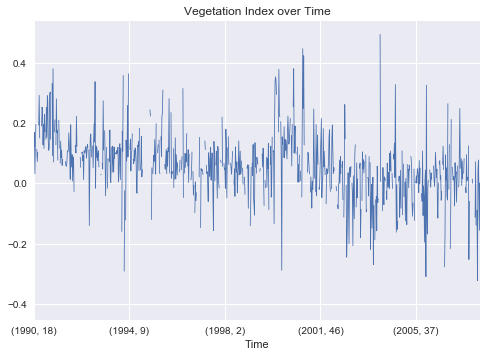

In [8]:
(sj_train_features
     .ndvi_ne
     .plot
     .line(lw=0.8))

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

In [9]:
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

In [10]:
print('San Juan')
print('mean: ', sj_train_labels.mean()[0])
print('var :', sj_train_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_train_labels.mean()[0])
print('var :', iq_train_labels.var()[0])

San Juan
mean:  34.1805555556
var : 2640.04543969

Iquitos
mean:  7.56538461538
var : 115.895523937


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001E5567B8>]], dtype=object)

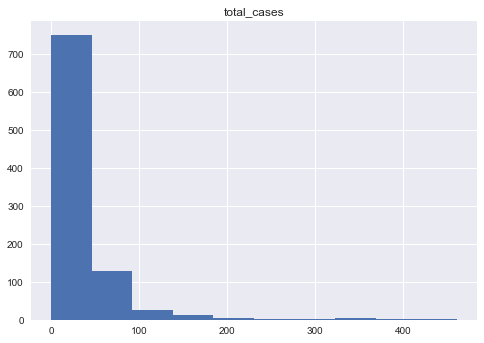

In [11]:
sj_train_labels.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001ED53898>]], dtype=object)

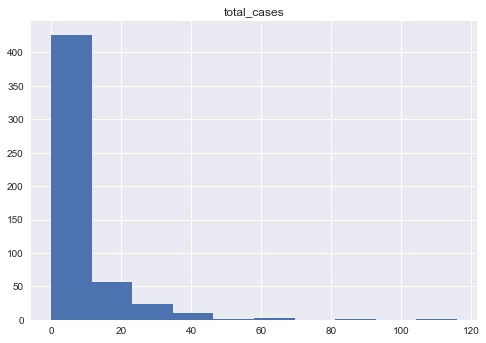

In [12]:
iq_train_labels.hist()

In [13]:
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

In [14]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

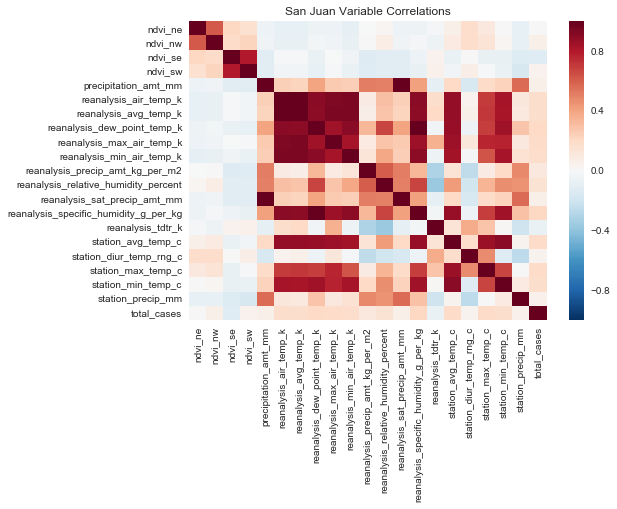

In [15]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

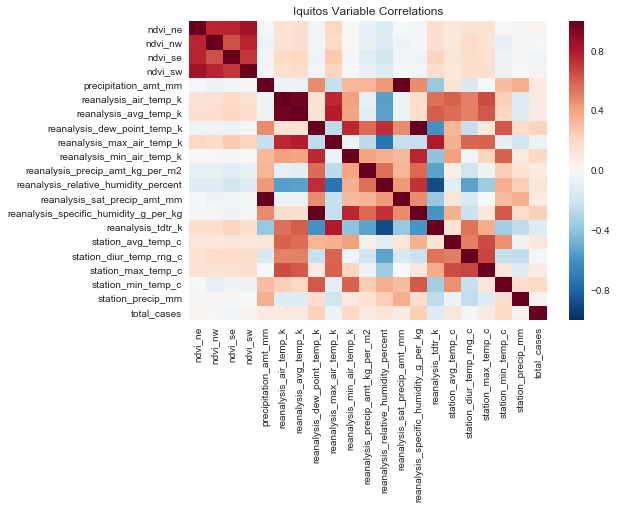

In [16]:
iq_corr_heat = sns.heatmap(iq_correlations)
plt.title('Iquitos Variable Correlations')

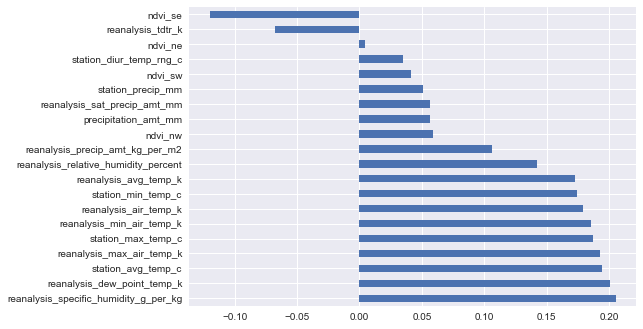

In [17]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

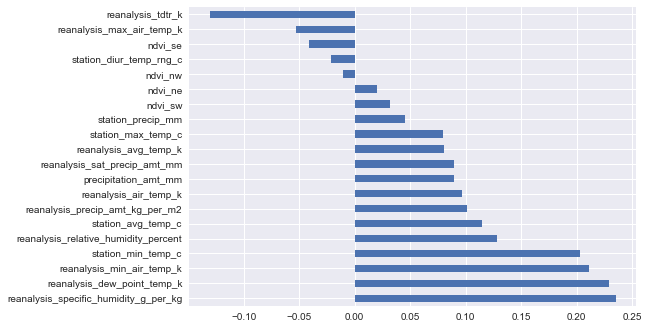

In [18]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

In [19]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c']
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [20]:
sj_train, iq_train = preprocess_data('data-processed/dengue_features_train.csv',
                                    labels_path="data-processed/dengue_labels_train.csv")

In [21]:
sj_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,936.000000,936.000000,936.000000,936.000000,936.000000
mean,16.547535,295.104736,26.999191,22.594017,34.180556
std,1.560663,1.570075,1.415079,1.506281,51.381372
min,11.715714,289.642857,22.842857,17.800000,0.000000
25%,15.233571,293.843929,25.842857,21.700000,9.000000
50%,16.835000,295.451429,27.214286,22.800000,19.000000
75%,17.854286,296.415714,28.175000,23.900000,37.000000
max,19.440000,297.795714,30.071429,25.600000,461.000000


In [22]:
iq_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,520.000000,520.000000,520.000000,520.000000,520.000000
mean,17.102019,295.498723,27.506331,21.210385,7.565385
std,1.443048,1.414360,0.908973,1.257734,10.765478
min,12.111429,290.088571,21.400000,14.700000,0.000000
25%,16.121429,294.596429,26.957500,20.600000,1.000000
50%,17.428571,295.852143,27.587500,21.400000,5.000000
75%,18.180357,296.557143,28.075000,22.000000,9.000000
max,20.461429,298.450000,30.800000,24.200000,116.000000


In [23]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

In [24]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_min_temp_c + " \
                    "station_avg_temp_c"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

best alpha =  1e-08
best score =  22.0808823529
best alpha =  1e-08
best score =  6.46666666667


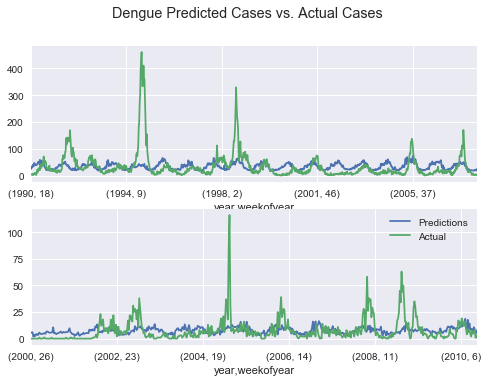

In [25]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

In [26]:
sj_test, iq_test = preprocess_data('data-processed/dengue_features_test.csv')

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

submission = pd.read_csv("data-processed/submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("data-processed/benchmark.csv")